In [42]:
# %matplotlib inline
%pylab inline
import scipy
from pyiga import bspline, assemble, vform, geometry, vis, solvers
import numpy as np
import matplotlib.pyplot as plt

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


c:\Users\mechadmin\Documents\GitHub\pyiga\.venv\lib\site-packages\IPython\core\magics\pylab.py:162: UserWarning: pylab import has clobbered these variables: ['grid', 'identity']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


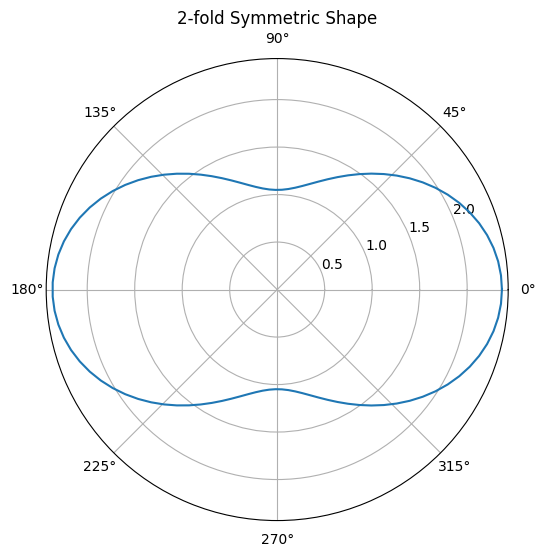

In [43]:
def cal_c(r, a, L0):
    return np.sqrt(2)*np.sqrt(np.pi*(3+3*r**2+2*r)*a*L0)/(np.pi*(3+3*r**2+2*r))
def superformula(theta, r, d, n, a, L0):
    c = cal_c(r,a,L0)
    return c*((1+r)-d*(-1)**((n+2)/2)*(r-1)*np.cos(n*theta))
d = 0.9
r = 0.4
n = 2
a = 0.4
L0 = 25
theta_values = np.linspace(0, 2 * np.pi, 100)
result = superformula(theta_values, r, d, n, a, L0)
plt.figure(figsize=(6, 6))
plt.polar(theta_values, result)
plt.title(f"{n}-fold Symmetric Shape")
plt.show()
def polar_to_cartesian(result, theta):
    x = result * np.cos(theta)
    y = result * np.sin(theta)
    return (x,y)
theta_values = np.linspace(0, 2 * np.pi, 100)
result = superformula(theta_values, r, d, n, a, L0)


In [46]:
def cal_c(r, a, L0):
    return np.sqrt(2)*np.sqrt(np.pi*(3+3*r**2+2*r)*a*L0)/(np.pi*(3+3*r**2+2*r))
def superformula(theta, r, d, n, a, L0):
    c = cal_c(r,a,L0)
    return c*((1+r)-d*(-1)**((n+2)/2)*(r-1)*np.cos(n*theta))
def polar_to_cartesian(result, theta):
    x = result * np.cos(theta)
    y = result * np.sin(theta)
    return (x,y)
def iga(kvs,geo):
    g = lambda x,y: 0  # Dirichlet BC function
    f = lambda x,y: 3 # source term

    # compute Dirichlet boundary conditions
    bcs = assemble.compute_dirichlet_bcs(kvs, geo, [('left', g), ('right', g)])

    # compute right-hand side from function f
    rhs = assemble.inner_products(kvs, f, f_physical=True, geo=geo).ravel()
    # set up and solve linear system
    A = assemble.stiffness(kvs, geo)
    LS = assemble.RestrictedLinearSystem(A, rhs, bcs)

    u = scipy.sparse.linalg.spsolve(LS.A, LS.b)
    u_func = geometry.BSplineFunc(kvs, LS.complete(u))
    return u_func
    


In [50]:
import matplotlib.pyplot as plt
from pyiga.geometry import *
from pyiga import approx, bspline
import os

# Define the folder name and path
desktop_path = os.path.join(os.path.expanduser('~'), 'Desktop')
folder_name = os.path.join(desktop_path, 'superformula_dataset')

# Create the folder if it doesn't exist
if not os.path.exists(folder_name):
    os.makedirs(folder_name)
    
# List of subfolders to be created
subfolders = ['parameters', 'nurbs', 'iga']

# Create each subfolder
paths = {}
for subfolder in subfolders:
    path = os.path.join(folder_name, subfolder)
    os.makedirs(path, exist_ok=True)
    paths[subfolder] = path
parameters_path = paths['parameters']
nurbs_path = paths['nurbs']
iga_path = paths['iga']
ns = np.arange(2, 12, 2).tolist()
rs = [round(num, 2) for num in np.arange(0.2, 0.9, 0.1).tolist()]
n_kv = 100
kv = bspline.make_knots(1, 0.0, 1.0, n_kv)
kv_iga = kvs = 2*(kv,)

num_res = kv.numdofs
theta_values = np.linspace(0, 2 * np.pi, num_res)
w = np.ones((1,num_res))
g = geometry.line_segment([0.5,0.5], [1,1])

d = 0.8
a = 0.1
L0 = 25
for n in ns:
    for r in rs:
        result = superformula(theta_values, r, d, n, a, L0)
        coeffs = np.array(polar_to_cartesian(result, theta_values))
        coeffs = np.vstack((coeffs, w)).transpose()
        nurbs = NurbsFunc((kv,), coeffs.copy(), weights=None)
        geo = geometry.outer_product(nurbs, g)
        grid = (np.linspace(0.0, 1.0, 8),)
        vis.plot_geo(geo, gridx = 50, gridy = 5, grid = grid, res = 400)
        plt.axis('equal')
        nurbs_pic = os.path.join(nurbs_path, f'file_n{n}_r{r}.png')
        plt.savefig(nurbs_pic)
        plt.clf()  # Clear the figure
        
        file_name = os.path.join(parameters_path, f'file_n{n}_r{r}.npz')
        np.savez(file_name, coeffs=coeffs, kvs=kv, 
                 r=r, n=n, d=d,a = a, L0 = L0)
        
        u_func = iga(kv_iga, geo)
        # plot coefficients and solution
        figsize(12,6)
        
        subplot(1,2,1)
        pcolormesh(u_func.coeffs)
        gca().set_aspect('equal')

        subplot(1,2,2)
        vis.plot_field(u_func, geo, res = 500)
        gca().set_aspect('equal')
        colorbar();
        iga_pic = os.path.join(iga_path, f'file_n{n}_r{r}.png')
        plt.savefig(iga_pic)
        plt.clf()  # Clear the figur
        

        


        

<Figure size 1200x600 with 0 Axes>

In [ ]:
# To load the file
for n in ns:
    for r in rs:
        file_name = os.path.join(folder_name, f'file_n{n}_r{r}.npz')
        data = np.load(file_name)
        # Access data
        loaded_matrix = data['matrix']
        loaded_array = data['array']
        loaded_int_param = data['int_param'][0]  # extract integer from array
        loaded_float_param = data['float_param'][0]  # extract float from array